In [1]:
import datetime
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
%matplotlib inline


import logging

logging.basicConfig(level=logging.INFO)

In [2]:
%load_ext autoreload
%autoreload 2
import c14
import c14.tools as tools
import c14.models.liver
import c14.models.liver_nonhepato
import c14.models.minimal
import c14.corner
import arviz as az


# Load Models

In [3]:
c14.models.liver_nonhepato.models_list 

[c14.models.minimal.POP1,
 c14.models.minimal.POP1q,
 c14.models.liver_nonhepato.POP2]

In [4]:
NUM=4
np.seterr(all='ignore')
results= dict()
#models_lista = ['R', 'R_kappa_wo_limit', 'R_kappa_wo_limit_k42_free']
#models_listb = [ 'D','L','R2K24']
#models_listc = [eval('c14.models.liver.'+mm) for mm in models_lista + models_listb]
for mm in c14.models.liver_nonhepato.models_list:
    m = mm()
    name = m.__class__.__name__
    try:
        with open('/scratch/ws/jrode-c14_liver/runs_non/'+name+'_'+str(NUM)+ '.pickle', 'rb') as handle:
            res = pickle.load(handle)
    except FileNotFoundError:
        print(m.__class__.__name__)
        continue
    results[m.__class__.__name__] = {'res':res,'m':m}

ERROR:c14.models.base:Default logparas missing. 
ERROR:c14.models.base:No linparas -> assuming all are logparas. 
ERROR:c14.models.base:Default linparas missing. Assuming all are logparas
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2


In [5]:
import arviz as az
burnin=1000
age = None
remove_stuck=True
for n,v in results.items():
    v['pe'] = c14.tools.find_point_estimate(v['res'],v['m'])
    v['azdata'],v['azdata_names'] = c14.tools.convert_to_arviz(v['res'],v['m'],burnin,remove_stuck=remove_stuck,iparas_time=age,phy_space=False)
    chsck = c14.tools.run_convergence_checks(v['azdata'])
    print(n)
    for i in chsck:
        print(i)
    print('\n')

model =  v['m']

2  chains are stuck
POP1
WARN: The number of effective samples is smaller than 10% for some parameters.


3  chains are stuck
POP1q
WARN: The number of effective samples is smaller than 10% for some parameters.


1  chains are stuck
POP2
INFO: The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
WARN: The number of effective samples is smaller than 10% for some parameters.




# model compression

In [9]:
az.compare({n:v['azdata'] for n,v in results.items()},ic='loo')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
POP1,0,-2.72563,0.816974,0,0.423081,2.33665,0,False,deviance
POP2,1,-2.59126,0.872109,0.134368,0.393521,2.66491,0.159394,False,deviance
POP1q,2,-0.959783,1.09475,1.76584,0.183398,2.37197,0.92526,False,deviance


# Posterior plot

2  chains are stuck
POP1
WARN: The number of effective samples is smaller than 10% for some parameters.


3  chains are stuck
POP1q
WARN: The number of effective samples is smaller than 10% for some parameters.


1  chains are stuck


POP2
INFO: The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
WARN: The number of effective samples is smaller than 10% for some parameters.





Attaching package: ‘gplots’



    lowess


/home/julian/pythonenv/c14/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


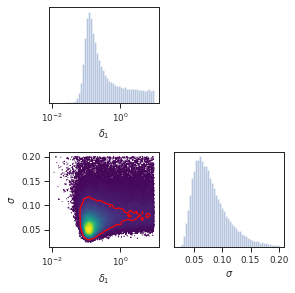

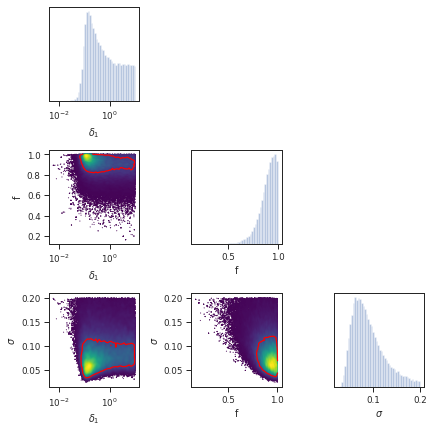

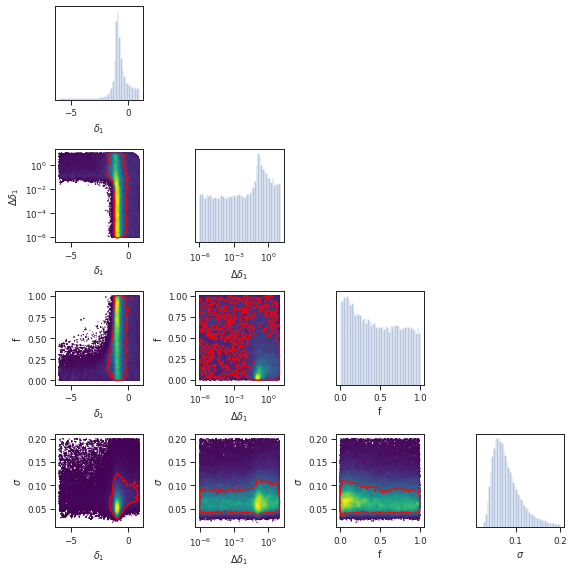

In [6]:
import jr.plot
import arviz as az
burnin=1000
age = None
remove_stuck=True
for n,v in results.items():
    v['pe'] = c14.tools.find_point_estimate(v['res'],v['m'])
    v['azdata'],v['azdata_names'] = c14.tools.convert_to_arviz(v['res'],v['m'],burnin,remove_stuck=remove_stuck,iparas_time=age,phy_space=False)
    chsck = c14.tools.run_convergence_checks(v['azdata'])
    print(n)
    for i in chsck:
        print(i)
    print('\n')
    
from matplotlib import rcParams,rc
import seaborn as sb
from mpl_toolkits.axes_grid1 import make_axes_locatable
fonts = 1
sb.set(context="paper",style='ticks',font_scale=fonts)
para_rename={'lambda_':r"$\delta_1$",'dlambda':r"$\Delta\delta_1$",'sigma':r"$\sigma$",
            'kappa24':r"$\kappa_{24}$",'kappa42':r"$\kappa_{42}$",
             'delta2':r"$\delta_2$",'delta4':r"$\delta_4$",
            'f':r"f",'lambda1':r"$\delta_1$"}
for n,v in results.items():  
    c14.corner.corner_R(v['azdata'].posterior.a.values,
                   v['m'].parameter_names,burnin=0,point_estimate=None,rename=para_rename,
                     logparas=['delta4','delta2','lambda_','dlambda','kappa24','kappa42'])    
    f = plt.gcf()
    f.show();
    #f.suptitle('hepato ' + n,fontsize=30)
    f.savefig('non-hepato'+n+'.png',dpi=600)

In [13]:
def median_sd(x):
     median = np.percentile(x, 50)
     sd = np.sqrt(np.mean((x-median)**2))
     return sd
func_dict = {
     "std": np.std,
     "median_std": median_sd,
     "percentile.1585": lambda x: np.percentile(x, 15.85),
     "median": lambda x: np.percentile(x, 50),
     "percentile.8415": lambda x: np.percentile(x, 84.15),
}

In [14]:
for n,v in results.items():
    print('finish,',n)
    all_times=[]
    #ages=[0,10,20,30,40,50,60,70,80]
    #ages = np.linspace(0,80,41)
    ages=[0]
    m = eval('c14.models.liver_nonhepato.'+n+'()')
    for age in ages:
        burnin=1000
        remove_stuck=True
        azdata,azdata_names = c14.tools.convert_to_arviz(v['res'],v['m'],burnin,remove_stuck=remove_stuck,iparas_time=age)
        summary = az.summary(azdata,round_to=8,credible_interval=0.683,stat_funcs=func_dict)
        summary.index = azdata_names
        real_median = {pn:summary.loc[pn,'median'] for pn in m.parameter_names}
        m.set_parameters_phy(real_median)
        real_median.update(m.calc_implicit_parameters(age))
        summary['real_median'] = pd.Series(real_median)
        all_times.append(summary)
    df = pd.concat(all_times)
    df.index = pd.MultiIndex.from_product([ages,azdata_names],names=['time','para'])
    with pd.HDFStore('final_v2_non_'+n+'_'+str(NUM)+'.pandas') as st:
        st['df'] = df
    v['allparas'] = df

ERROR:c14.models.base:Default logparas missing. 
ERROR:c14.models.base:No linparas -> assuming all are logparas. 
ERROR:c14.models.base:Default linparas missing. Assuming all are logparas
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2


finish, POP1
2  chains are stuck


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2


finish, POP1q
3  chains are stuck


ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2


finish, POP2
1  chains are stuck


In [15]:
excel_writer = pd.ExcelWriter('non_hepatocyte_final_v2.xlsx')

for n,v in results.items():
    df = v['allparas'][['real_median','hpd_15.85%','hpd_84.15%']].unstack().rename(columns={'hpd_15.85%':'lower','hpd_84.15%':'upper'})
    df_new=df.copy()
    cols = df_new.columns
    new_cols = [(i2,i1) for i1,i2 in cols]
    df_new.columns=pd.MultiIndex.from_tuples(new_cols)
    df_new=df_new.reindex(sorted(df_new.columns), axis=1)
    
    df_new.to_excel(excel_writer=excel_writer,sheet_name=n)
excel_writer.save()